In [55]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from six.moves import urlli
import tensorflow.compat.v2.feature_column as fc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

test = pd.read_csv("data/test.csv")
train =pd.read_csv("data/train.csv")

find out correlation matrix in tensorflow
confusion matrix
recall
p values
probablity based models
logistic regression


In [56]:
#cleaning data  
SPECIES = ['Closed', 'Open']
dftest = test.drop(columns=["CustomerId", "Surname","Balance","id"])
dftrain = train.drop(columns=["CustomerId", "Surname","Balance","id"])

dftrain['HasCrCard']=pd.Series(np.where(dftrain.HasCrCard.values == 0.0, 0, 1),dftrain.index) #setting these to an int without a decimal
dftest['HasCrCard']=pd.Series(np.where(dftest.HasCrCard.values == 0.0, 0, 1),dftest.index)
dftrain['IsActiveMember']=pd.Series(np.where(dftrain.IsActiveMember.values == 0.0, 0, 1),dftrain.index) #setting these to an int without a decimal
dftest['IsActiveMember']=pd.Series(np.where(dftest.IsActiveMember.values == 0.0, 0, 1),dftest.index)


y = dftrain.pop('Exited')

X_train, X_eval, y_train, y_eval = train_test_split(dftrain, y, test_size=0.15, random_state=1)


#y_train=dftrain.pop('Exited')
#testdata doesn't have Exited test_y=dftest.pop('Exited')
#need to switch the balance to 0 and 1s
#dftrain['Exited']=pd.Series(np.where(dftrain.Exited.values == 0, 0, 1),dftrain.index)
#dftest['Exited']=pd.Series(np.where(dftest.Exited.values == 0, 0, 1),dftest.index)

#Changed modes SPECIES = ['Closed', 'Open']
#dfeval = dftrain.iloc[:-1000]
#y_eval = y_train.iloc[:-1000]
X_eval.head()


,CreditScore,Geography,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
51719,659,Germany,Male,48.0,4,2,0,1,134094.02
77286,756,Germany,Female,54.0,4,4,1,0,7166.71
43625,636,France,Male,46.0,5,1,1,0,48986.18
26151,613,France,Male,47.0,3,2,1,1,17802.42
60732,711,Germany,Female,51.0,4,1,0,0,172618.52


In [57]:

X_train.describe()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,140278.000000,140278.000000,140278.000000,140278.000000,140278.000000,140278.000000,140278.000000
mean,656.406685,38.132314,5.021921,1.555076,0.754523,0.497712,112497.066333
std,80.129412,8.878197,2.808255,0.547598,0.430371,0.499997,50344.878111
min,350.000000,18.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,597.000000,32.000000,3.000000,1.000000,1.000000,0.000000,74510.650000
50%,659.000000,37.000000,5.000000,2.000000,1.000000,0.000000,117946.300000
75%,710.000000,42.000000,7.000000,2.000000,1.000000,1.000000,154985.882500
max,850.000000,92.000000,10.000000,4.000000,1.000000,1.000000,199992.480000


In [58]:
X_train.shape

(140278, 9)

<Axes: >

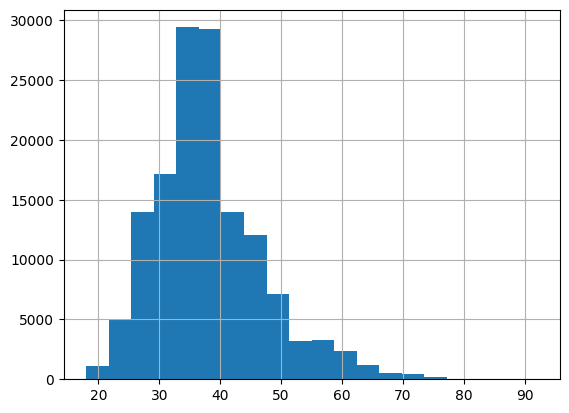

In [59]:
X_train.Age.hist(bins=20)

<Axes: >

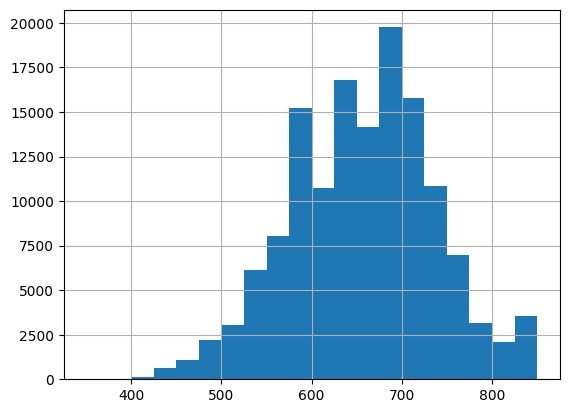

In [60]:
X_train.CreditScore.hist(bins=20)

Text(0.5, 0, 'percent exited')

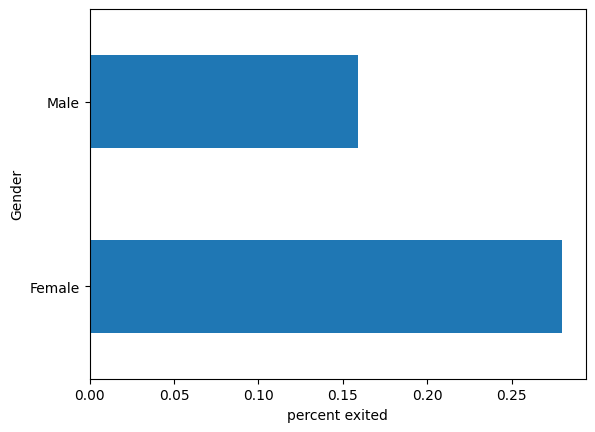

In [61]:
pd.concat([X_train, y_train], axis=1).groupby('Gender').Exited.mean().plot(kind='barh').set_xlabel('percent exited')

In [62]:
CATEGORICAL_COLUMNS = ['Geography', 'Gender','Tenure', 'NumOfProducts','HasCrCard','IsActiveMember']
NUMERIC_COLUMNS = ['Age','CreditScore', 'EstimatedSalary'] #wasn't 100% sure on which was which

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = X_train[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [63]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(X_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(X_eval, y_eval, num_epochs=1, shuffle=False)



In [64]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier
clear_output()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\zslus\\AppData\\Local\\Temp\\tmpxslb2lnj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [65]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data
clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model


0.8000889


In [66]:
print(result)

{'accuracy': 0.8000889, 'accuracy_baseline': 0.7872031, 'auc': 0.56461185, 'auc_precision_recall': 0.32325935, 'average_loss': 11.7810135, 'label/mean': 0.2127969, 'loss': 11.7809105, 'precision': 0.6609485, 'prediction/mean': 0.040175695, 'recall': 0.12433561, 'global_step': 43840}
